In [12]:
import os
os.getcwd()

os.chdir(os.path.join(os.environ["HOME"], "Code/jwst/"))

In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import Image

from exotedrf import utils, stage1, stage2

os.environ['CRDS_PATH'] = './crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

In [2]:
# Generate output directories
utils.verify_path('/data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory')
utils.verify_path('/data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory/Stage1')
utils.verify_path('/data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory/Stage2')

In [3]:
# First define some input and output directory paths.

uncal_indir = '/data/typhon2/hattie/jwst/wasp_96/DMS_uncal/'  # Where our uncalibrated files are found.
outdir_s1 = '/data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory/Stage1/'  # Where to save our Stage 1 output files.

No. integrations: 11
No. groups: 14
subarray: SUBSTRIP256


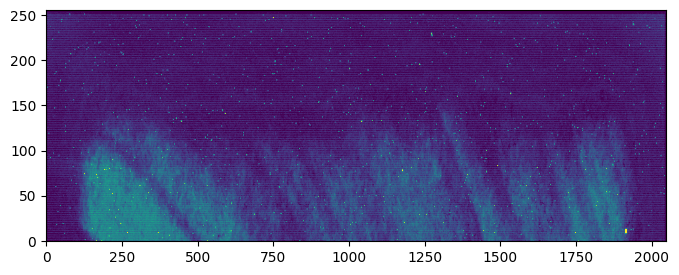

In [4]:

filepath = os.path.join(uncal_indir, "jw02734002001_04102_00001-seg001_nis_uncal.fits")

with fits.open(filepath) as file:
    print('No. integrations: {}'.format(file[0].header['NINTS']))
    print('No. groups: {}'.format(file[0].header['NGROUPS']))
    print('subarray: {}'.format(file[0].header['SUBARRAY']))
    plt.figure(figsize=(8, 3))
    # Let's check out the last group of the 10th integration
    plt.imshow(file[1].data[10, -1], aspect='auto', origin='lower',
               vmin=1e4, vmax=3e4)
    plt.show()

In [5]:
step = stage1.DQInitStep(filepath, deepframe=None, output_dir=outdir_s1)

# Now run the step!

results = step.run(save_results=True, force_redo=True)

2024-09-12 16:04:51,623 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2024-09-12 16:04:53,749 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2024-09-12 16:04:53,877 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (<Level1bModel(11, 14, 256, 2048) from jw02734002001_04102_00001-seg001_nis_uncal.fits>,).
2024-09-12 16:04:53,879 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory/Stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2024-09-12 16:04:53,979 - stpipe.DQInitStep - INFO - Using MASK reference file ./crds_cache/references/jwst/niriss/jwst_niriss_mask_0017.fits
2024-09-12 16:04:54,247 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2024-09-12 16:04:54,364 - stpip

In [6]:
dq_init_file = os.path.join(outdir_s1, "jw02734002001_04102_00001-seg001_nis_dqinitstep.fits")
step = stage1.SuperBiasStep(dq_init_file, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True, do_plot=True)

2024-09-12 16:04:55,573 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2024-09-12 16:04:55,596 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2024-09-12 16:04:55,724 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(11, 14, 256, 2048) from jw02734002001_04102_00001-seg001_nis_dqinitstep.fits>,).
2024-09-12 16:04:55,726 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory/Stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2024-09-12 16:04:55,761 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file ./crds_cache/references/jwst/niriss/jwst_niriss_superbias_0200.fits
2024-09-12 16:04:56,040 - stpipe.SuperBiasStep - INFO - Results used CRDS context: jwst_1281

2024-09-12 16:04:57.027 - exoTEDRF - INFO - Doing diagnostic plot.
2024-09-12 16:04:58.348 - exoTEDRF - INFO - Plot saved to /data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory/Stage1/superbiasstep.png


In [13]:
background_model = "model_background256.npy"
step = stage2.BackgroundStep(results, background_model=background_model,
                             baseline_ints=[150, -100], output_dir=outdir_s1)

results, bkg = step.run(save_results=True, differential=True, force_redo=True, do_plot=True)

2024-09-12 16:13:29.706 - exoTEDRF - INFO - Reading background model file: model_background256.npy...
2024-09-12 16:13:29.709 - exoTEDRF - INFO - BackgroundStep instance created.
2024-09-12 16:13:29.709 - exoTEDRF - INFO - Starting background subtraction step.
2024-09-12 16:13:29.709 - exoTEDRF - INFO - Generating a median stack using baseline integrations.


IndexError: index 11 is out of bounds for axis 0 with size 11

In [ ]:
pixel_masks = None
timeseries = None
step = stage1.OneOverFStep(results, baseline_ints=[150, -100], output_dir=outdir_s1,
                           pixel_masks=pixel_masks, soss_timeseries=timeseries,
                           method='scale-achromatic', soss_background=bkg)
results = step.run(save_results=True, even_odd_rows=True, force_redo=True, do_plot=True,
                   soss_inner_mask_width=40)

In [ ]:
step = stage1.RampFitStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

2024-09-12 15:55:54,382 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2024-09-12 15:55:54,403 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2024-09-12 15:55:54,550 - stpipe.RampFitStep - INFO - Step RampFitStep running with args (<RampModel(11, 14, 256, 2048) from jw02734002001_04102_00001-seg001_nis_superbiasstep.fits>,).
2024-09-12 15:55:54,553 - stpipe.RampFitStep - INFO - Step RampFitStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /data/typhon2/hattie/jwst/wasp_96/pipeline_outputs_directory/Stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  int_name: ''
  save_opt: False
  opt_name: ''
  suppress_one_group: True
  maximum_cores: quarter
2024-09-12 15:55:54,588 - CRDS - INFO -  Fetching  ./crds_cache/references/jwst/niriss/jwst_niriss_readnoise_0005.fits   16.8 M bytes  (1 / 1 files) (0 / 16.8 M

2024-09-12 15:58:08.622 - exoTEDRF - INFO - Doing cosmetic NaN interpolation.
2024-09-12 15:58:14.647 - exoTEDRF - INFO - Step RampFitStep really done.


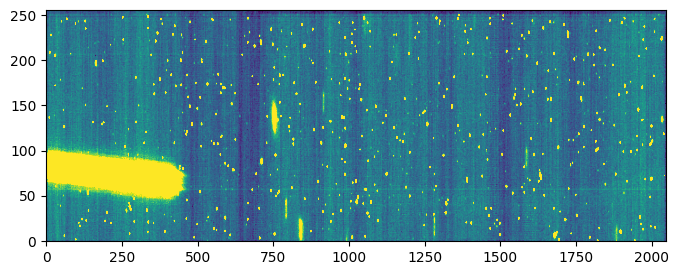

In [ ]:
with fits.open(os.path.join(outdir_s1, "jw02734002001_04102_00001-seg001_nis_rampfitstep.fits")) as file:
    plt.figure(figsize=(8, 3))
    plt.imshow(file[1].data[0], aspect='auto', origin='lower', vmin=0, vmax=1)
    plt.show()